# Setup

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import grad
import jax
import matplotlib.pyplot as plt
import networkx as nx
from sklearn import datasets
import optax  

# Load the Iris dataset 

In [2]:
iris = datasets.load_iris()
X = iris.data


X[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [3]:
# Calculate a similarity matrix 
sim_matrix = 1 - np.abs(np.corrcoef(X.T))
sim_matrix

array([[0.        , 0.88243022, 0.12824622, 0.18205887],
       [0.88243022, 0.        , 0.5715599 , 0.63387407],
       [0.12824622, 0.5715599 , 0.        , 0.03713457],
       [0.18205887, 0.63387407, 0.03713457, 0.        ]])

# Train

In [4]:
# Function to construct the precision matrix
def construct_precision_matrix(params, p):
  lambda_ = 0.001

  precision_matrix = jnp.zeros((p, p))
  for i in range(p):
    for j in range(i, p):
      if i != j:
        precision_matrix = precision_matrix.at[i, j].set(params[i * p + j])
      
  precision_matrix += precision_matrix.T
  precision_matrix += jnp.diag(jnp.diag(precision_matrix)) # Using jnp.diag 

  # Soft-thresholding for L1 regularization
  precision_matrix = jnp.sign(precision_matrix) * jnp.maximum(jnp.abs(precision_matrix) - lambda_, 0)
  return precision_matrix

# Define the squared loss function
@jax.jit
def squared_loss(params, X):
  n, p = X.shape
  predicted_precision = construct_precision_matrix(params, p)
  empirical_cov = (1 / n) * jnp.dot(X.T, X)
  return 0.5 * jnp.trace(jnp.dot(predicted_precision, empirical_cov)) + jnp.sum(jnp.abs(params))


In [5]:
p = X.shape[1]
key = jax.random.PRNGKey(758493)  # Random seed is explicit in JAX
params = jax.random.uniform(key, (p * (p + 1) // 2, ))
display(params)

# Optimization setup (using Optax)
loss_grad = grad(squared_loss)  
optimizer = optax.adam(0.01) 
opt_state = optimizer.init(params) 

# Training loop with Optax update
for i in range(1000):
  updates, opt_state = optimizer.update(loss_grad(params, sim_matrix), opt_state)
  params = optax.apply_updates(params, updates)
  if i % 100 == 0:
    print(f"Loss at step {i} is {squared_loss(params, sim_matrix)}")

Array([0.70291924, 0.57264924, 0.48725235, 0.39568925, 0.92254746,
       0.24538016, 0.8512181 , 0.6274457 , 0.13381684, 0.38589656],      dtype=float32)

Loss at step 0 is 5.459306240081787
Loss at step 100 is 0.05052885413169861
Loss at step 200 is 0.011818405240774155
Loss at step 300 is 0.009851031936705112
Loss at step 400 is 0.011032850481569767
Loss at step 500 is 0.014219274744391441
Loss at step 600 is 0.01734934002161026
Loss at step 700 is 0.013720372691750526
Loss at step 800 is 0.01638551615178585
Loss at step 900 is 0.006963142193853855


In [6]:
# Estimated precision and covariance matrices
estimated_precision_matrix = construct_precision_matrix(params, p)
estimated_covariance_matrix = jnp.linalg.inv(estimated_precision_matrix)

display(estimated_precision_matrix)

Array([[ 0.        , -0.00170827, -0.00434623, -0.        ],
       [-0.00170827,  0.        ,  0.        ,  0.00268845],
       [-0.00434623,  0.        ,  0.        ,  0.000421  ],
       [-0.        ,  0.00268845,  0.000421  ,  0.        ]],      dtype=float32)

# Visualization



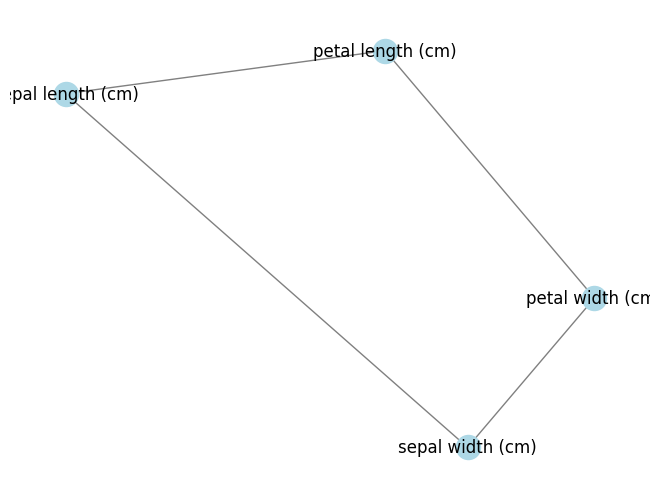

In [7]:

G = nx.from_numpy_array(np.abs(estimated_covariance_matrix))
G = nx.relabel_nodes(G, {i: names for i, names in enumerate(iris.feature_names)})
nx.draw(G, node_color='lightblue', edge_color='gray', with_labels=True) 
plt.show()